In [1]:
import numpy as np
# from utils import timer, load_config, get_current_dt, load_npz, f1_score
import utils as ut
import os
import log
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import itertools
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import gradient_descent_v2
from keras.layers import BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
logger = log.get_logger(__name__)

In [15]:
@ut.timer
def define_model(num_conv_layers=2, num_filters=32, filter_size=3, 
                 num_dense_layers=1, dense_units=128, 
                 learning_rate=0.001, momentum=0.9, activation='relu',
                 padding='same', use_batch_norm=False, use_dropout=False,
                 dropout_rate=0.2, use_early_stopping=True, patience=2):
    """
    Defines a CNN model with the specified number of convolutional and dense layers, number of filters, filter size,
    learning rate, and momentum for the optimizer. Options for batch normalization, dropout, and early stopping are
    included.
    """
    model = Sequential()
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(num_filters, (filter_size, filter_size), activation=activation, 
                             kernel_initializer='he_uniform', padding=padding, input_shape=(32, 32, 3)))
        else:
            model.add(Conv2D(num_filters, (filter_size, filter_size), activation=activation, 
                             kernel_initializer='he_uniform', padding=padding))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add dense layers
    for i in range(num_dense_layers):
        model.add(Dense(dense_units, activation=activation, kernel_initializer='he_uniform'))
        if use_batch_norm:
            model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(dropout_rate))
    # Add output layer
    model.add(Dense(10, activation='softmax'))
    # Compile the model with the specified optimizer, learning rate, and momentum
    opt = gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', ut.f1_score])
    if use_early_stopping:
        es = EarlyStopping(monitor='val_loss', patience=patience)
        logger.info(f"Using EarlyStopping with patience={patience}.")
        logger.info(f"Model defined: {model.summary()}")
        return model, es
    else:
        logger.info(f"Model defined: {model.summary()}")
        return model
    
@ut.timer
def train_model(model, trainX, trainY, valX, valY, batch_size, epochs,
                model_path, model_name, combination_num, datetime):
    """
    Trains the CNN model on the training set and validates on the validation set.
    """
    # define the callback to save the weights
    checkpoint = ModelCheckpoint(f'{model_path}{model_name}_{combination_num}_{datetime}.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 save_weights_only=True, 
                                 verbose=1)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        callbacks=[checkpoint], 
                        batch_size=batch_size, 
                        epochs=epochs,
                        verbose=1)    
    return history

@ut.timer
def plot_performance(history, dataset):
    """
    Plots the loss and accuracy curves and saves the figure to file.
    """
    # create figure with two subplots
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Cross Entropy Loss', 'Classification Accuracy'))
    # plot loss
    fig.add_trace(px.line(history.history, x=history.epoch, y=['loss', 'val_loss'], labels={'value': 'loss', 'variable': ''}).data[0], row=1, col=1)
    # plot accuracy
    fig.add_trace(px.line(history.history, x=history.epoch, y=['accuracy', 'val_accuracy'], labels={'value': 'accuracy', 'variable': ''}).data[0], row=2, col=1)
    # update layout
    fig.update_layout(title=f'{dataset.capitalize()} CIFAR-10 Classification', width=800, height=600)
    return fig
    
@ut.timer
def train_models(conf, trainX, trainY, valX, valY):
    """
    Trains multiple models with different hyperparameters.
    """
    # generate all possible combinations of hyperparameters
    param_values = list(itertools.product(*conf.a1_q1_hyperparams.values()))
    param_names = list(conf.a1_q1_hyperparams.keys())

    for i, params in enumerate(param_values):
        logger.info(f"Training model {i} with Params: {params}")
        datetime = ut.get_current_dt()
        # create dictionary of hyperparameters for this model
        param_dict = dict(zip(param_names, params))
        # define model with current set of hyperparameters
        model = define_model(**param_dict)
        # train model with current set of hyperparameters
        history = train_model(model, trainX, trainY, valX, valY, 
                              conf.a1_q1_params.batch_size, 
                              conf.a1_q1_params.epochs,
                              conf.paths.a1_model, "cifar10", i, datetime)
        # save trained model and training history
        # save_model(conf.paths.a1_model, "cifar10", i, datetime)
        ut.save_history(conf.paths.a1_history, history, "cifar10", i, datetime)
        fig = plot_performance(history, dataset="validation")
        ut.save_plot(conf.paths.a1_reporting_plots, fig, "validation", datetime)

# @ut.timer
# def main():
#     # load config
#     conf = ut.load_config()
#     # load data
#     data = ut.load_npz(f"{conf.paths.a1_raw_data}cifar10.npz")
#     # split training data into training and validation sets
#     trainX, trainY, valX, valY = ut.split_dataset(data['trainX'], data['trainY'])
#     # convert image data to float32 and normalize
#     trainX, _, valX = ut.convert_image_data(trainX, data['testX'], valX)
#     # one-hot encode labels
#     trainY, _, valY = ut.encode_labels(trainY, data['testY'], valY)
#     # train models
#     train_models(conf, trainX, trainY, valX, valY)

def _check_trainable_layers(model):
    # get the configuration of each layer
    layer_configs = model.get_config()['layers']

    # print whether each layer is trainable or not
    for i, layer_config in enumerate(layer_configs):
        layer = model.layers[i]
        logger.info(f"Layer {i}: {layer.name}, trainable={layer.trainable}")

In [4]:
# ut.save_model(model_path="../data/06_models/", model=base_model, model_name="vgg16", combination_num="base_model", datetime=ut.get_current_dt())

In [19]:
@ut.timer
def load_pretrained_model(pretrained_model, weights, include_top=False):
    # Load pre-trained VGG16 model without the top layer (which includes the classification layers)
    base_model = pretrained_model(weights=weights, include_top=False, input_shape=(32, 32, 3))
    return base_model


@ut.timer
def add_new_layers(base_model, dense_units, activation):
    # Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(units=dense_units, activation=activation)(x)
    predictions = Dense(10, activation='softmax')(x) # For CIFAR10 data

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

@ut.timer
def freeze_layers(base_model):
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    _check_trainable_layers(base_model)
    return base_model

@ut.timer
def unfreeze_layers(base_model):
    # Unfreeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = True
    _check_trainable_layers(base_model)
    return base_model


def _check_trainable_layers(model):
    # get the configuration of each layer
    layer_configs = model.get_config()['layers']

    # print whether each layer is trainable or not
    for i, layer_config in enumerate(layer_configs):
        layer = model.layers[i]
        logger.info(f"Layer {i}: {layer.name}, trainable={layer.trainable}")

@ut.timer
def compile_model(model, loss, metrics, learning_rate=0.0001, momentum=0.9):
    opt = gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum)
    # We need to recompile the model for these modifications to take effect
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

@ut.timer
def train_model(model, trainX, trainY, valX, valY, batch_size, epochs,
                model_path, model_name, combination_num, datetime):
    """
    Trains the CNN model on the training set and validates on the validation set.
    """
    # define the callback to save the weights
    checkpoint = ModelCheckpoint(f'{model_path}{model_name}_{combination_num}_{datetime}.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 save_weights_only=True, 
                                 verbose=1)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        callbacks=[checkpoint], 
                        batch_size=batch_size, 
                        epochs=epochs,
                        verbose=1)    
    return history

In [12]:
# load config
conf = ut.load_config()
# load data
data = ut.load_npz(f"{conf.paths.a1_raw_data}cifar10.npz")
# split training data into training and validation sets
trainX, trainY, valX, valY = ut.split_dataset(data['trainX'], data['trainY'])
# convert image data to float32 and normalize
trainX, _, valX = ut.convert_image_data(trainX, data['testX'], valX)
# one-hot encode labels
trainY, _, valY = ut.encode_labels(trainY, data['testY'], valY)
# get datetime
datetime = ut.get_current_dt()

29-Apr-23 22:46:31 - INFO - Starting 'load_config'.
29-Apr-23 22:46:31 - INFO - Finished 'load_config' in 0.0188 secs.
29-Apr-23 22:46:31 - INFO - Starting 'load_npz'.
29-Apr-23 22:46:31 - INFO - Loaded npz file from ../data/01_raw/cifar10.npz.
29-Apr-23 22:46:31 - INFO - Finished 'load_npz' in 0.0007 secs.
29-Apr-23 22:46:32 - INFO - Starting 'split_dataset'.
29-Apr-23 22:46:32 - INFO - Starting '_shuffle_data'.
29-Apr-23 22:46:32 - INFO - Finished '_shuffle_data' in 0.0457 secs.
29-Apr-23 22:46:32 - INFO - Finished 'split_dataset' in 0.0464 secs.
29-Apr-23 22:46:32 - INFO - Starting 'convert_image_data'.
29-Apr-23 22:46:32 - INFO - Finished 'convert_image_data' in 0.2362 secs.
29-Apr-23 22:46:32 - INFO - Starting 'encode_labels'.
29-Apr-23 22:46:32 - INFO - Finished 'encode_labels' in 0.0008 secs.


In [13]:
base_model = load_pretrained_model(pretrained_model=VGG16, weights='imagenet', include_top=False)

29-Apr-23 22:46:36 - INFO - Starting 'load_pretrained_model'.
29-Apr-23 22:46:36 - INFO - Finished 'load_pretrained_model' in 0.2476 secs.


In [17]:
freeze_layers(base_model)

29-Apr-23 22:47:50 - INFO - Starting 'freeze_layers'.
29-Apr-23 22:47:50 - INFO - Layer 0: input_2, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 1: block1_conv1, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 2: block1_conv2, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 3: block1_pool, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 4: block2_conv1, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 5: block2_conv2, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 6: block2_pool, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 7: block3_conv1, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 8: block3_conv2, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 9: block3_conv3, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 10: block3_pool, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 11: block4_conv1, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 12: block4_conv2, trainable=False
29-Apr-23 22:47:50 - INFO - Layer 13: block4_conv3, trainable=False
29-Apr-23 22

In [20]:
model = add_new_layers(base_model, dense_units=512, activation='relu')

29-Apr-23 22:49:36 - INFO - Starting 'add_new_layers'.
29-Apr-23 22:49:36 - INFO - Finished 'add_new_layers' in 0.0274 secs.


In [21]:
compile_model(model, loss='categorical_crossentropy', metrics=['accuracy'])

29-Apr-23 22:50:05 - INFO - Starting 'compile_model'.
29-Apr-23 22:50:05 - INFO - Finished 'compile_model' in 0.0084 secs.


In [22]:
history = train_model(model, trainX, trainY, valX, valY, batch_size=32, epochs=10,
                            model_path=conf.paths.a1_model, model_name="vgg16", combination_num="base_model", datetime=datetime)

29-Apr-23 22:50:22 - INFO - Starting 'train_model'.
2023-04-29 22:50:22.268978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-29 22:50:22.271912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2023-04-29 22:50:29.245298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1248/1250 [============================>.] - ETA: 0s - loss: 2.2393 - accuracy: 0.1878

2023-04-29 22:50:49.086216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 32s 20ms/step - loss: 2.2391 - accuracy: 0.1880 - val_loss: 2.0321 - val_accuracy: 0.3361

Epoch 00001: val_accuracy improved from -inf to 0.33610, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 2/10
1250/1250 [==============================] - 24s 19ms/step - loss: 1.9762 - accuracy: 0.3638 - val_loss: 1.8651 - val_accuracy: 0.3926

Epoch 00002: val_accuracy improved from 0.33610 to 0.39260, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 3/10
1250/1250 [==============================] - 24s 19ms/step - loss: 1.8288 - accuracy: 0.4078 - val_loss: 1.7619 - val_accuracy: 0.4201

Epoch 00003: val_accuracy improved from 0.39260 to 0.42010, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 4/10
1250/1250 [==============================] - 24s 19ms/step - loss: 1.7322 - accuracy: 0.4301 - val_loss: 1.6918 - val_accuracy: 0.4295

Epoch 00004: val_accuracy i

29-Apr-23 22:54:36 - INFO - Finished 'train_model' in 253.9169 secs.



Epoch 00010: val_accuracy improved from 0.47610 to 0.48200, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5


In [23]:
unfreeze_layers(base_model)

29-Apr-23 23:18:54 - INFO - Starting 'unfreeze_layers'.
29-Apr-23 23:18:54 - INFO - Layer 0: input_2, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 1: block1_conv1, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 2: block1_conv2, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 3: block1_pool, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 4: block2_conv1, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 5: block2_conv2, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 6: block2_pool, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 7: block3_conv1, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 8: block3_conv2, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 9: block3_conv3, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 10: block3_pool, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 11: block4_conv1, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 12: block4_conv2, trainable=True
29-Apr-23 23:18:54 - INFO - Layer 13: block4_conv3, trainable=True
29-Apr-23 23:18:54 - INF

In [24]:
# compile model
compile_model(model, loss='categorical_crossentropy', metrics=['accuracy'])
# train model

29-Apr-23 23:19:54 - INFO - Starting 'compile_model'.
29-Apr-23 23:19:54 - INFO - Finished 'compile_model' in 0.0093 secs.


In [25]:
history = train_model(model, trainX, trainY, valX, valY, batch_size=32, epochs=10,
                            model_path=conf.paths.a1_model, model_name="vgg16", combination_num="base_model", datetime=datetime)
   

29-Apr-23 23:19:56 - INFO - Starting 'train_model'.


Epoch 1/10


2023-04-29 23:19:57.296657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 1.1228 - accuracy: 0.6104

2023-04-29 23:21:06.392727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 75s 59ms/step - loss: 1.1227 - accuracy: 0.6105 - val_loss: 0.7886 - val_accuracy: 0.7247

Epoch 00001: val_accuracy improved from -inf to 0.72470, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 2/10
1250/1250 [==============================] - 72s 57ms/step - loss: 0.7192 - accuracy: 0.7477 - val_loss: 0.6708 - val_accuracy: 0.7680

Epoch 00002: val_accuracy improved from 0.72470 to 0.76800, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 3/10
1250/1250 [==============================] - 72s 58ms/step - loss: 0.5941 - accuracy: 0.7888 - val_loss: 0.6415 - val_accuracy: 0.7752

Epoch 00003: val_accuracy improved from 0.76800 to 0.77520, saving model to ../data/06_models/A1/vgg16_base_model_29042023_224632.h5
Epoch 4/10
1250/1250 [==============================] - 72s 58ms/step - loss: 0.5113 - accuracy: 0.8200 - val_loss: 0.5899 - val_accuracy: 0.7948

Epoch 00004: val_accuracy i

29-Apr-23 23:32:18 - INFO - Finished 'train_model' in 741.7037 secs.



Epoch 00010: val_accuracy did not improve from 0.82390


In [ ]:
@ut.timer
def main():
    # load config
    conf = ut.load_config()
    # load data
    data = ut.load_npz(f"{conf.paths.a1_raw_data}cifar10.npz")
    # split training data into training and validation sets
    trainX, trainY, valX, valY = ut.split_dataset(data['trainX'], data['trainY'])
    # convert image data to float32 and normalize
    trainX, _, valX = ut.convert_image_data(trainX, data['testX'], valX)
    # one-hot encode labels
    trainY, _, valY = ut.encode_labels(trainY, data['testY'], valY)
    # get datetime
    datetime = ut.get_current_dt()
    # load pre-trained model
    base_model = load_pretrained_model(pretrained_model=VGG16, weights='imagenet', include_top=False)
    # freeze layers
    freeze_layers(base_model)
    # add new layers
    model = add_new_layers(base_model, dense_units=512, activation='relu')
    # compile model
    compile_model(model, loss='categorical_crossentropy', metrics=['accuracy'])
    # train model
    history = train_model(model, trainX, trainY, valX, valY, batch_size=32, epochs=10,
                            model_path=conf.paths.a1_model, model_name="vgg16", combination_num="base_model", datetime=datetime)
    # unfreeze layers
    unfreeze_layers(base_model)
    # compile model
    compile_model(model, loss='categorical_crossentropy', metrics=['accuracy'])
    # train model
    history = train_model(model, trainX, trainY, valX, valY, batch_size=32, epochs=10,
                            model_path=conf.paths.a1_model, model_name="vgg16", combination_num="base_model", datetime=datetime)
    # save trained model and training history
    ut.save_history(conf.paths.a1_history, history, "cifar10", "", datetime)
    fig = plot_performance(history, dataset="validation")
    ut.save_plot(conf.paths.a1_reporting_plots, fig, "validation", datetime)
    

## Evaluating an object detection model

In [39]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

In [27]:
# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

/opt/homebrew/Caskroom/miniforge/base/envs/mlai_cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/ashwineekumarpandey/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:47<00:00, 3.51MB/s] 


In [33]:
# Load an image
image = Image.open('../data/01_raw/example_afghanhound.jpg')
image_tensor = F.to_tensor(image).unsqueeze(0)

In [34]:
# Perform the detection
with torch.no_grad():
    prediction = model(image_tensor)[0]

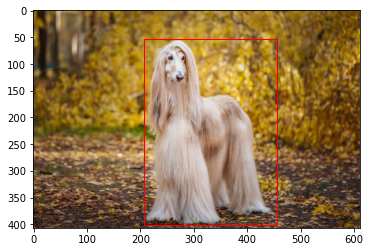

In [35]:
# Display the image with bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Draw bounding boxes
for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
    if score > 0.5:  # Only consider detections with a confidence score above 0.5
        x, y, width, height = box[0].item(), box[1].item(), box[2].item() - box[0].item(), box[3].item() - box[1].item()
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.show()

### Load test set

In [40]:
# Specify the path to your CSV file
file_path = '../data/01_raw/validation-annotations-bbox.csv'

# Define the column names
column_names = ['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin', 'YMax', 
                'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside']

# Read the CSV file
data = pd.read_csv(file_path, skiprows=1, names=column_names)

In [41]:
data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303975,ffff21932da3ed01,xclick,/m/03fp41,1,0.178125,0.710938,0.412500,0.579167,0,0,1,0,0
303976,ffff21932da3ed01,xclick,/m/01g317,1,0.000000,0.015625,0.345833,0.414583,0,1,0,1,0
303977,ffff21932da3ed01,xclick,/m/01g317,1,0.062500,0.085938,0.431250,0.529167,1,0,0,0,0
303978,ffff21932da3ed01,xclick,/m/0c9ph5,1,0.323437,0.409375,0.464583,0.554167,0,0,1,0,0


In [43]:
import fiftyone as fo
import fiftyone.zoo as foz

# List available zoo datasets
print(foz.list_zoo_datasets())

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

In [38]:




# Extract the first 100 image IDs
image_ids = data['ImageID'][:100]

# Write to a text file
with open('../data/02_intermediate/open_images_v6_subset100.txt', 'w') as f:
    for id in image_ids:
        f.write('validation/' + id + '\n')